<a href="https://colab.research.google.com/github/ezulfica/School-Projects/blob/main/Sparsity%20estimation/Sparsity%2C_estimation_and_features_selections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#About tresholding

In this exercice we observe the following gaussian mixture model : 
$$ y_j = a \eta_j + \xi_j , \quad j = 1, ... , d $$ 

where $a \in \mathbb{R}$ , $\eta_j \in \{0,1 \}$, $ \xi_j \sim \mathcal{N}(0,1)$ with condition :  $$ \sum_{j=1}^d \eta_j = \lfloor d^{1-\beta} \rfloor \text{  with } β \in [0,1]$$ 

For the next part, we will estimate our observations according to the values of a and build the empiric risk function. 

We will use three estimator : hard tresholding, soft tresholding and non negative garotte

In [2]:
def generate_eta(d, beta) : 
  """ function to generate a vector of eta """
  limit = int(d**(1-beta))
  eta = np.concatenate([np.ones(limit), np.zeros(d-limit)])
  np.random.shuffle(eta)
  return eta

In [3]:
def HT(y,tau) : 
  return y*(np.abs(y) > tau) 

def ST(y,tau) : 
  return y * (1 - tau/np.abs(y)) * (np.abs(y) > tau)

def NNG(y,tau) : 
  return y* (1- (tau/y)**2) * (y**2 >= tau**2)

In [143]:
d = 50
beta = 0.3
tau = np.sqrt(2* np.log(d))

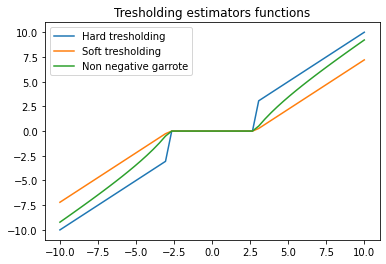

In [ ]:
y = np.linspace(-10,10, d)
plt.plot(y, HT(y, tau))
plt.plot(y, ST(y, tau))
plt.plot(y, NNG(y, tau))
plt.legend(["Hard tresholding", "Soft tresholding", "Non negative garrote"])
plt.title("Tresholding estimators functions")
plt.show();

## Quadratic Risk

In [ ]:
def quad_risk(a_min, a_max, step_a, d, beta, tau, estimator, n) : 
  """
  Compute the quadratic risk between our estimator and our target. 
  We generate the observed y according to its definition
  Currently looking for a way to optimize the prcecess without for loop 

  Parameters
        ----------
        a_min : minimum of a
        a_max : maximum of a
        step_a : to generate a sequence of number between a_min and a_max
        d : number of observation
        beta : real between 0 and 1 for the precedent definition with eta
        tau : treshold for the estimator
        estimator : a tresholding function (HT, ST or NNG for example)
        n : number of simulation for Monte-Carlo simulation
  
  Then we return a dictionnary with the values of a, the mean square error for each a and the standard deviation of the risk
  """
  a_val = np.linspace(a_min, a_max, step_a)
  risk_values_mean = [] #MSE
  risk_values_std = [] #SD of MSE
  for a in a_val : 
    risk_val = []
    for i in range(n) : 
      theta_star = a*generate_eta(d, beta) #for each loop, with generate a theta sequence
      y = theta_star + np.random.randn(d) #vector of y
      theta_hat = estimator(y, tau) #theta_hat value for y
      risk = np.sum((theta_star - theta_hat)**2) #quadratic risk
      risk_val.append(risk) 
    risk_values_mean.append(np.mean(risk_val)) #for each  a we add the mean square error
    risk_values_std.append(np.std(risk_val)) #for each a we add the std of the risk
  return {"a_val" : a_val , "risk_values" : np.array(risk_values_mean) , "std" : np.array(risk_values_std)}

In [ ]:
d, beta, tau, n = 50, 0.3, np.sqrt(2*np.log(d)), 50
a_min, a_max, step_a =  1 , 10, 20
estimator = {
    "HT" : quad_risk(a_min = a_min, a_max = a_max, step_a = step_a, d = d, beta = beta, tau = tau, estimator = HT, n = n),
    "ST" : quad_risk(a_min = a_min, a_max = a_max, step_a = step_a, d = d, beta = beta, tau = tau, estimator = ST, n = n),
    "NNG" : quad_risk(a_min = a_min, a_max = a_max, step_a = step_a, d = d, beta = beta, tau = tau, estimator = NNG, n = n) 
}

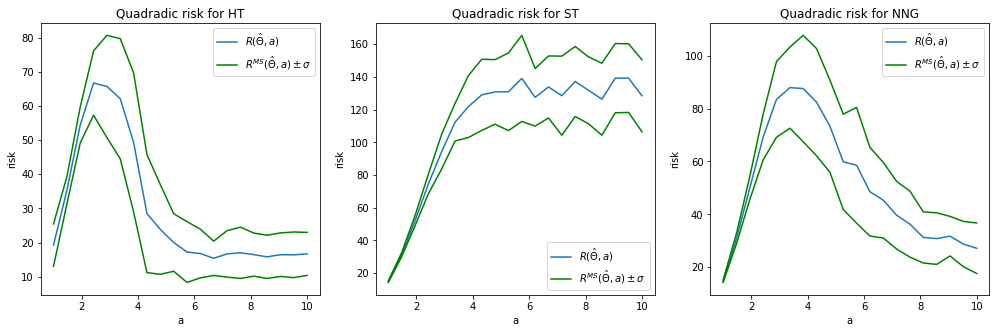

In [ ]:
fig, ax = plt.subplots(nrows =1, ncols = 3, figsize = (17,5))
i = 0
for estim in estimator : 

  sns.lineplot(
      x = estimator[estim]["a_val"], y = estimator[estim]["risk_values"], ax = ax[i]
      )
  
  sns.lineplot(
      x = estimator[estim]["a_val"], y = estimator[estim]["risk_values"] + estimator[estim]["std"], 
      ax = ax[i], color = "green"
      )
  
  sns.lineplot(
      x = estimator[estim]["a_val"], y = estimator[estim]["risk_values"] - estimator[estim]["std"], 
      ax = ax[i], color = "green"
      )
  
  ax[i].set_title("Quadradic risk for " + estim)
  ax[i].legend([r'$R(\hat{\Theta}, a)$', r'$R^{MS}(\hat{\Theta}, a) \pm \sigma$'])
  ax[i].set_xlabel("a")
  ax[i].set_ylabel("risk")
  i += 1


## Selection Risk

We define, for the tresholding estimators, the selection risk : 
$$ R^{MS}(\hat{\theta},a) = \sum^d_{j=1} |\eta_j - \hat{\eta}_j | 
\\ 
where \text{ }\hat{\eta}_j = \mathbb{1}_{|y_j| > τ}$$



In [ ]:
def selection_risk(a_min, a_max, step_a, d, beta, tau, n) : 
  """
  Compute the selection risk between our estimator and our target. 
  We generate the observed y according to its definition
  Currently looking for a way to optimize the prcecess without for loop 

  Parameters
        ----------
        a_min : minimum of a
        a_max : maximum of a
        step_a : to generate a sequence of number between a_min and a_max
        d : number of observation
        beta : real between 0 and 1 for the precedent definition with eta
        tau : treshold for the estimator

        n : number of simulation for Monte-Carlo simulation
  
  Then we return a dictionnary with the values of a, the mean square error for each a and the standard deviation of the risk
  """
  a_val = np.linspace(a_min, a_max, step_a)
  risk_selection_mean = []
  risk_selection_std = []
  for a in a_val : 
    
    risk_val = []
    for i in range(n) : 
      eta = generate_eta(d, beta)
      y = a * eta + np.random.randn(d)
      eta_hat = 1*(np.abs(y) > tau)
      risk_select = np.sum(np.abs(eta - eta_hat))
      risk_val.append(risk_select)

    risk_selection_mean.append(np.mean(risk_val))
    risk_selection_std.append(np.std(risk_val))
  return {"a_val" : a_val , "risk_values" : np.array(risk_selection_mean) , "std" : np.array(risk_selection_std)}

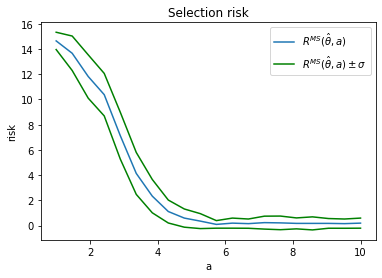

In [ ]:
r_select = selection_risk(a_min = a_min, a_max =a_max, step_a = step_a , d = d, beta = beta, tau = tau, n = n)
sns.lineplot(x = r_select["a_val"], y = r_select["risk_values"])
sns.lineplot(x = r_select["a_val"], y = r_select["risk_values"] + r_select["std"], color = "green")
sns.lineplot(x = r_select["a_val"], y = r_select["risk_values"] - r_select["std"], color = "green")
plt.title("Selection risk")
plt.xlabel("a")
plt.ylabel("risk")
plt.legend([r'$R^{MS}(\hat{\theta},a)$', r'$R^{MS}(\hat{\theta},a) \pm \sigma$'])
plt.show();

# Rupture detection

Let's suppose the following gaussian mixture model : 
$$ y_j = θ^{*}_j + \epsilon · \xi_j $$ 
with $ϵ = \frac{1}{\sqrt{d}}$, d the number of observations.

The goal is to estimate $$J^* = \{j \in \{2,...,d\} \ | \ \theta^*_j \neq \theta_{j-1}^* \}$$

where : 
$
  \theta^*_j = 3 \ for \ j \in \{1,..,10\} \\
  \theta^*_j = 7 \ for \ j \in \{11,..,30\} \\
  \theta^*_j = 1.5 \ for \ j \in \{31,..,40\} \\
  \theta^*_j = 2 \ for \ j \in \{41,..,d\}
$


## Estimation

In [5]:
#Parameters 
d = 50
epsilon = 1/np.sqrt(d)
#to generate theta_star for a d value
theta_star_j = lambda j,d : (3*(1<= j <=10) + 7*(11<= j <=30) + 1.5*(31<= j <=40) + 2*(41<= j <= d))*(d>= 41)

In [6]:
def J_star_exo2(d) : 
  theta_star = np.array([theta_star_j(j,d) for j in range(1,d+1)])
  j_star = np.where(theta_star[1:] - theta_star[:-1] != 0)[0] + 2
  return(j_star)

J_star = J_star_exo2(50)
print(f"J_star = {J_star} ")

J_star = [11 31 41] 


In order to estimate $J^*$ we looks, iteratively, for the sequence starting from $j=1$ then looking for which value $j_0$ verifies :  
$$ |\bar{θ}_{n} - y_n| > \tau  $$
with $ \bar{θ}_{n} = \frac{1}{n-n_0} \sum^n_{j = n_0} y_j $


Then we start over for $j = n_0$

The only constraint is to define a good value for $\tau$ 

In [270]:
def rupture_detection(tau, y) : 
  """
  Compute the rupture detection for a sequence of values.  

  Parameters
        ----------
        tau : treshold of rupture
        y : array of values
  
  Then we return a list containing each point where there is a significant difference between the mean
  """
  
  #Initialazing parameters
  theta_hat = np.cumsum(y) / np.array([i for i in range(1,len(y)+1)]) #empiric mean vector
  new_y = y #a copy of y, which is going to be reduced through computing
  theta_hat_new = theta_hat #a copy of theta_hat, which is going to be reduced through computing
  J_hat = [] #empty list for the value of rupture
  rupture_point = 0 #initalazing value of rupture point at zero

  #We looks for each values where the square difference between theta_hat and y is greater than tau
  #When the len will be equal to zero, the loop will stop

  while len(np.where(np.abs(theta_hat_new - new_y) > tau)[0]) > 0 :    
    #Picking the first value where theta_hat_bar - y is greater than tau
    rupture_point = np.where(np.abs(theta_hat_new - new_y) > tau)[0][0] + rupture_point + 1 
    J_hat.append(rupture_point)
    #reducing our sequence in order to start from the rupture point
    new_y = y[rupture_point:]
    #computing the new empiric mean for each value
    theta_hat_new = np.cumsum(new_y) / np.array([i for i in range(1,len(new_y)+1)])

   #returning J_hat 
  return np.array(J_hat) 

In [280]:
y  = np.array([theta_star_j(j, d) for j in range(1,d+1)]) + np.random.randn(d) * epsilon #Generating y
J_hat = rupture_detection(0.3, y) #Detect the rupture for tau = 0.2
print(J_hat)

[11 31 41]


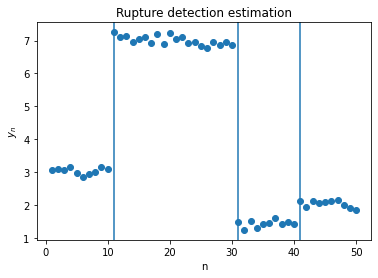

In [281]:
plt.scatter(range(1,d+1), y)
for j in J_hat : 
  plt.axvline(x = j)
plt.title("Rupture detection estimation")
plt.xlabel("n")
plt.ylabel(r"$y_n$")
plt.show();


## Application with a database

In [180]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [188]:
df = pd.read_table("drive/MyDrive/SGD1/secom.data", sep = " ", decimal = ".", header = None)

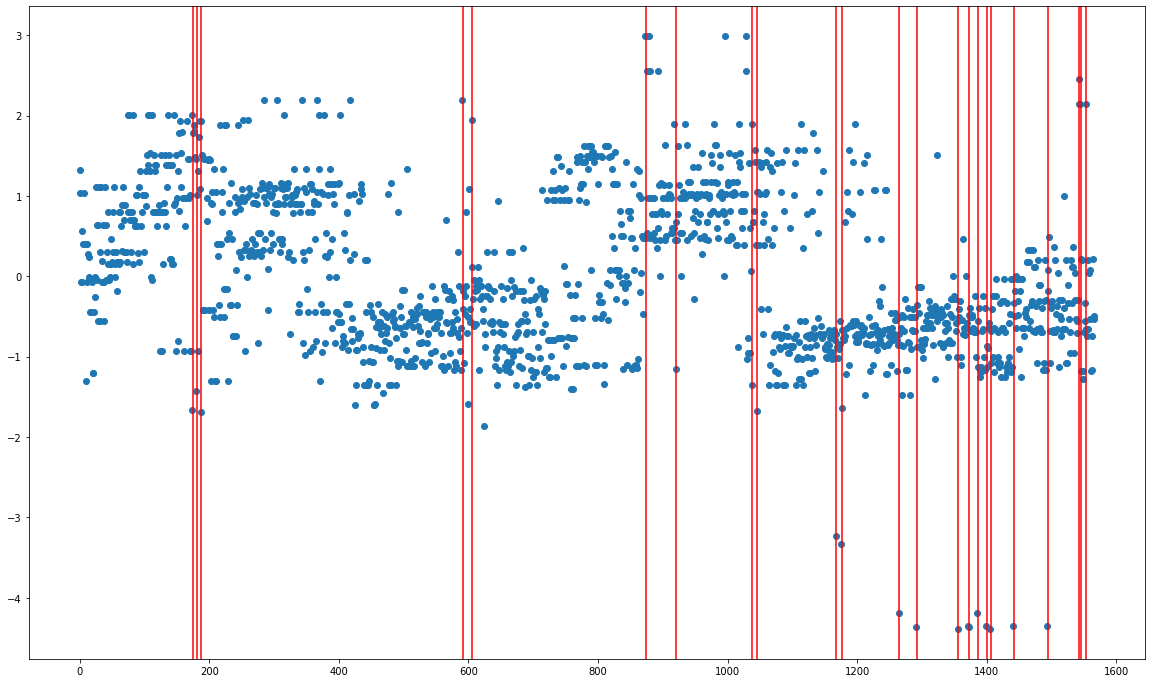

In [351]:
y = df[df.columns[58]]
y = (y - np.mean(y)) / np.std(y) 
plt.figure(figsize= (20,12))
plt.scatter(y.index, y)
for j in rupture_detection(2.1, y) :
  plt.axvline(x = j, color = "red")

With observations not as continuous per section as the first example, it's difficult to separate the values by the mean. 
Rather than looking for patterns, it's more looking for outlier 